In [187]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from numpy import ndarray
import sklearn.metrics as metrics
import sklearn.model_selection as skms  # noqa: F401
import sklearn.linear_model as sklm  # noqa: F401
import sklearn.impute as skimp
from sklearn.base import BaseEstimator
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import seaborn as sns  # noqa: F401
import matplotlib.pyplot as plt  # noqa: F401

import functools  # noqa: F401

In [188]:
np.random.seed(2025)

In [189]:
# train-validation-test data splitting


def trn_vld_tst_split(
    features: ndarray | DataFrame,
    target: ndarray | Series,
    train_size: float = 0.6,
    standardize_features: bool = True,
) -> tuple[ndarray, ndarray, ndarray, ndarray, ndarray, ndarray]:
    if isinstance(features, ndarray):
        X = features.copy()
    elif isinstance(features, DataFrame):
        X = features.to_numpy()
    else:
        raise TypeError("'features' is not of type DataFrame or ndarray")

    if isinstance(target, ndarray):
        y = target.copy()
    elif isinstance(target, Series):
        y = target.to_numpy()
    else:
        raise TypeError("'target' is not of type Series or ndarray")

    indices = np.arange(len(y))
    np.random.shuffle(indices)

    vld_start = int(len(indices) * train_size)
    tst_start = int(len(indices) * ((1 - train_size) / 2)) + vld_start

    trn_indices = indices[:vld_start]
    vld_indices = indices[vld_start:tst_start]
    tst_indices = indices[tst_start:]

    X_trn = X[trn_indices]
    X_vld = X[vld_indices]
    X_tst = X[tst_indices]

    if standardize_features:
        scaler = StandardScaler()
        X_trn = scaler.fit_transform(X_trn)
        X_vld = scaler.transform(X_vld)
        X_tst = scaler.transform(X_tst)

    return (
        X_trn,
        y[trn_indices],
        X_vld,
        y[vld_indices],
        X_tst,
        y[tst_indices],
    )


In [190]:
def show_metrics(
    model: BaseEstimator,
    X_trn: ndarray,
    y_trn: ndarray,
    X_vld: ndarray,
    y_vld: ndarray,
    X_tst: ndarray,
    y_tst: ndarray,
):
    name = type(model).__name__
    print(f"{name}\n{'*' * len(name)}")
    print()
    model.fit(X_trn, y_trn)

    for split_name, split in zip(
        ("Training", "Validation", "Testing"),
        ((X_trn, y_trn), (X_vld, y_vld), (X_tst, y_tst)),
    ):
        print(f"{split_name}\n{'-' * len(split_name)}")
        X_split, y_split = split
        y_hat = model.predict(X_split)
        print(f"Accuracy = {metrics.accuracy_score(y_split, y_hat)}")
        print(f"Confusion Matrix:\n{metrics.confusion_matrix(y_split, y_hat)}")
        print()

In [191]:
def get_metrics(
    model: BaseEstimator,
    X_trn: ndarray,
    y_trn: ndarray,
    X_vld: ndarray,
    y_vld: ndarray,
    X_tst: ndarray,
    y_tst: ndarray,
) -> tuple[
    tuple[float, float, float, ndarray],
    tuple[float, float, float, ndarray],
    tuple[float, float, float, ndarray],
]:
    """
    Returns a tuple containing accuracy, precision, recall, and the confusion matrix
    """
    model.fit(X_trn, y_trn)

    results = []

    for split in ((X_trn, y_trn), (X_vld, y_vld), (X_tst, y_tst)):
        X_split, y_split = split
        y_hat = model.predict(X_split)
        results.append(
            (
                metrics.accuracy_score(y_split, y_hat),
                metrics.precision_score(y_split, y_hat, average="macro"),
                metrics.confusion_matrix(y_split, y_hat),
            )
        )

    return tuple(results)

In [192]:
df = pd.read_csv(r"data/PS_2025.04.22_06.25.22.csv", skiprows=128)

/tmp/ipykernel_213651/3665899426.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"data/PS_2025.04.22_06.25.22.csv", skiprows=128)


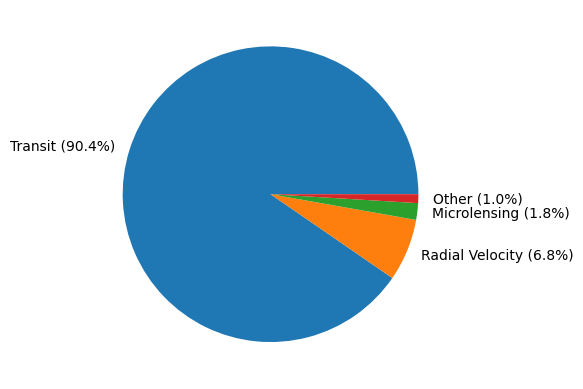

In [193]:
counts = df["discoverymethod"].value_counts()

breakdown = counts[:3]
breakdown["Other"] = counts[3:].sum()

plt.pie(
    breakdown,
    labels=[f"{label} ({(num / len(df)):.1%})" for label, num in breakdown.items()],
)
plt.show()

In [194]:
df = df[
    df["discoverymethod"].isin(
        (
            "Transit",
            "Radial Velocity",
            "Microlensing",
        )
    )
]
df

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,...,2014-05-14,2008-01,2014-05-14,2,1,2,0,0,0,0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,...,2014-07-23,2011-08,2014-07-23,2,1,2,0,0,0,0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,...,2023-09-19,2023-08,2023-09-19,2,1,2,0,0,0,0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0,0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,...,2018-04-25,2009-10,2014-05-14,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38383,38384,ups And d,ups And,d,HD 9826,HIP 7513,TIC 189576919,Gaia DR2 348020448377061376,1,2,...,2019-01-28,2011-01,2019-01-31,5,1,10,1,0,0,0
38384,38385,ups Leo b,ups Leo,b,NaN,NaN,TIC 49430557,Gaia DR2 3794167001116433152,1,1,...,2022-01-10,2021-12,2022-01-10,0,0,0,0,0,0,0
38385,38386,xi Aql b,xi Aql,b,HD 188310,HIP 97938,TIC 375464367,Gaia DR2 4298361114750843904,0,1,...,2014-07-23,2011-08,2014-07-23,1,1,1,0,0,0,0
38386,38387,xi Aql b,xi Aql,b,HD 188310,HIP 97938,TIC 375464367,Gaia DR2 4298361114750843904,0,1,...,2014-05-14,2008-06,2014-05-14,1,1,1,0,0,0,0


In [195]:
y = df["discoverymethod"]

y.value_counts()

discoverymethod
Transit            34704
Radial Velocity     2614
Microlensing         700
Name: count, dtype: int64

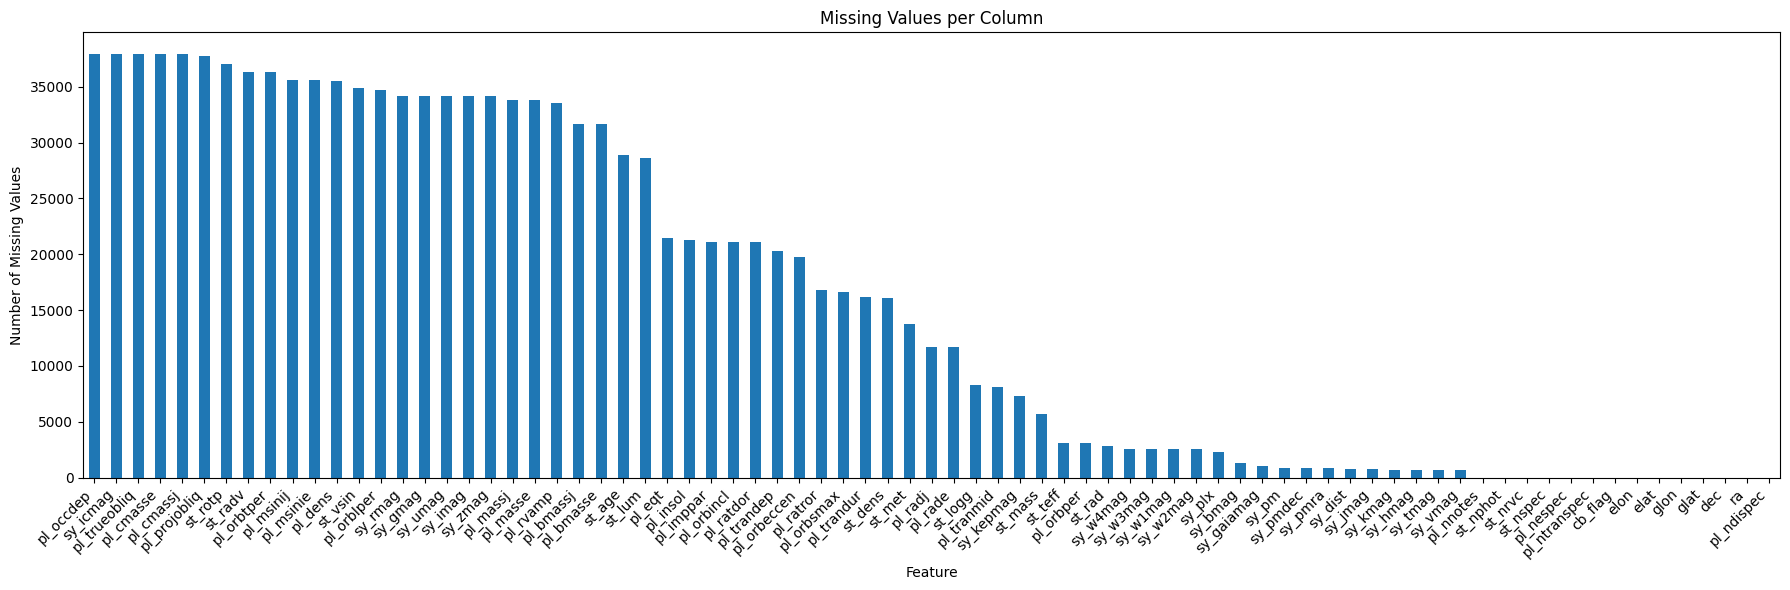

In [ ]:
missing_counts = (
    df.select_dtypes(include=[np.number])
    .drop(
        columns=[
            "rowid",
            "disc_year",
            *(
                col
                for col in df.columns
                if (col.endswith("_flag") and col != "cb_flag") or col.endswith("num")
            ),
        ]
    )
    .isna()
    .sum()
)

missing_counts = missing_counts.sort_values(ascending=False)

plt.figure(figsize=(18, 6))
missing_counts.plot.bar()
plt.xlabel("Feature")
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Column")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [196]:
X_num = (
    df[[col for col in df.columns if df[col].isna().sum() / df.shape[0] < 0.1]]
    .select_dtypes(include=[np.number])
    .drop(
        columns=[
            "rowid",
            "disc_year",
            *(
                col
                for col in df.columns
                if (col.endswith("_flag") and col != "cb_flag") or col.endswith("num")
            ),
        ]
    )
)

X_num

,cb_flag,pl_orbper,st_teff,st_rad,ra,dec,glat,glon,elat,elon,...,sy_w4mag,sy_gaiamag,sy_tmag,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,0,326.03000,4742.0,19.00,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,2.270,4.44038,3.83790,2,1,2,0,0,0,0
1,0,NaN,NaN,NaN,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,2.270,4.44038,3.83790,2,1,2,0,0,0,0
2,0,323.21000,4874.0,13.76,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,2.270,4.44038,3.83790,2,1,2,0,0,0,0
3,0,516.21997,4213.0,29.79,229.274595,71.823943,41.04437,108.71900,74.95821,141.64699,...,1.787,4.56216,3.82294,0,1,1,0,0,0,0
4,0,516.22000,4340.0,24.08,229.274595,71.823943,41.04437,108.71900,74.95821,141.64699,...,1.787,4.56216,3.82294,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38383,0,1276.46000,NaN,1.56,24.198353,41.403815,-20.66791,132.00045,28.97913,38.54864,...,NaN,3.98687,3.61370,5,1,10,1,0,0,0
38384,0,385.20000,4836.0,11.22,174.237219,-0.823564,56.79861,267.26323,-3.04521,175.03659,...,1.940,4.03040,3.44620,0,0,0,0,0,0,0
38385,0,NaN,NaN,NaN,298.562449,8.461105,-9.85535,47.81277,28.72199,302.62958,...,2.216,4.42501,3.81440,1,1,1,0,0,0,0
38386,0,136.75000,4780.0,12.00,298.562449,8.461105,-9.85535,47.81277,28.72199,302.62958,...,2.216,4.42501,3.81440,1,1,1,0,0,0,0


In [197]:
X_miss = X_num.isna().astype(int).rename(lambda col: f"{col}_missing", axis=1)

X_miss

,cb_flag_missing,pl_orbper_missing,st_teff_missing,st_rad_missing,ra_missing,dec_missing,glat_missing,glon_missing,elat_missing,elon_missing,...,sy_w4mag_missing,sy_gaiamag_missing,sy_tmag_missing,pl_nnotes_missing,st_nphot_missing,st_nrvc_missing,st_nspec_missing,pl_nespec_missing,pl_ntranspec_missing,pl_ndispec_missing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38383,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
38384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38385,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
assert y.shape[0] == X_num.shape[0] and X_num.shape == X_miss.shape, (
    "Inconsistent number of rows."
)

In [199]:
df_num = pd.concat([y, X_num], axis=1)

df_num.groupby("discoverymethod").apply(lambda g: g.isna().mean(), include_groups=False)

,cb_flag,pl_orbper,st_teff,st_rad,ra,dec,glat,glon,elat,elon,...,sy_w4mag,sy_gaiamag,sy_tmag,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
discoverymethod,,,,,,,,,,,,,,,,,,,,,
Microlensing,0.0,0.974286,0.964286,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Radial Velocity,0.0,0.020275,0.218439,0.368783,0.0,0.0,0.0,0.0,0.0,0.0,...,0.364193,0.009564,0.001530,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Transit,0.0,0.067283,0.052703,0.033310,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026510,0.008097,0.000317,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
knn_imp = KNNImputer(n_neighbors=5, weights="uniform")

X_num_filled = knn_imp.fit_transform(X_num)

X_num = DataFrame(X_num_filled, columns=X_num.columns, index=X_num.index)

In [201]:
X = pd.concat([X_num, X_miss], axis=1)

X

,cb_flag,pl_orbper,st_teff,st_rad,ra,dec,glat,glon,elat,elon,...,sy_w4mag_missing,sy_gaiamag_missing,sy_tmag_missing,pl_nnotes_missing,st_nphot_missing,st_nrvc_missing,st_nspec_missing,pl_nespec_missing,pl_ntranspec_missing,pl_ndispec_missing
0,0.0,326.030000,4742.000,19.00000,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,0,0,0,0,0,0,0,0,0,0
1,0.0,894.452490,5508.600,7.15000,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,0,0,0,0,0,0,0,0,0,0
2,0.0,323.210000,4874.000,13.76000,185.178779,17.793252,78.28058,264.13775,18.33392,177.41790,...,0,0,0,0,0,0,0,0,0,0
3,0.0,516.219970,4213.000,29.79000,229.274595,71.823943,41.04437,108.71900,74.95821,141.64699,...,0,0,0,0,0,0,0,0,0,0
4,0.0,516.220000,4340.000,24.08000,229.274595,71.823943,41.04437,108.71900,74.95821,141.64699,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38383,0.0,1276.460000,6084.456,1.56000,24.198353,41.403815,-20.66791,132.00045,28.97913,38.54864,...,1,0,0,0,0,0,0,0,0,0
38384,0.0,385.200000,4836.000,11.22000,174.237219,-0.823564,56.79861,267.26323,-3.04521,175.03659,...,0,0,0,0,0,0,0,0,0,0
38385,0.0,605.023716,5275.100,5.12917,298.562449,8.461105,-9.85535,47.81277,28.72199,302.62958,...,0,0,0,0,0,0,0,0,0,0
38386,0.0,136.750000,4780.000,12.00000,298.562449,8.461105,-9.85535,47.81277,28.72199,302.62958,...,0,0,0,0,0,0,0,0,0,0


In [202]:
assert not X.isna().any().any(), "Missing data is present, data is not imputed."

In [203]:
encoder = LabelEncoder()
encoder.fit(y)

y_label: ndarray = encoder.transform(y)

y_label

array([1, 1, 1, ..., 1, 1, 1], shape=(38018,))

In [204]:
X_trn, y_trn, _, _, _, _ = trn_vld_tst_split(X, y_label)

In [205]:
y_trn = Series(y_trn, name="discoverymethod")
X_trn = DataFrame(X_trn, columns=X.columns)

freq = y_trn.value_counts(normalize=True)

trn = pd.concat([y_trn, X_trn], axis=1)

weights = trn["discoverymethod"].map(lambda c: 1.0 / (freq[c] ** 0.2))
weights /= weights.sum()

In [206]:
n = len(trn)

bootstrapped = trn.sample(
    n=n,
    replace=True,
    weights=weights,
)

y_trn = bootstrapped["discoverymethod"]
X_trn = bootstrapped.drop(columns="discoverymethod")

In [207]:
# from sklearn.feature_selection import SequentialFeatureSelector

# rfc = RandomForestClassifier(max_depth=3)

# sfs = SequentialFeatureSelector(
#     rfc,
#     n_features_to_select=6,
#     direction="forward",
#     scoring="accuracy",
#     cv=3,
#     n_jobs=-1,
# )
# sfs.fit(X_trn, y_trn)
# print("SFS picked:", X.columns[sfs.get_support()])

# # SFS picked: Index(['pl_orbper', 'elon', 'sy_dist', 'sy_kmag', 'sy_pm_missing',
# #        'sy_plx_missing'],
# #       dtype='object')


In [213]:
selected_cols = [
    "pl_orbper",
    "dec",
    "elon",
    "sy_hmag",
    "st_rad_missing",
    "sy_pmdec_missing",
]

In [214]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = trn_vld_tst_split(
    X[selected_cols],
    y_label,
)

In [225]:
X_trn

,pl_orbper,dec,elon,sy_hmag,st_rad_missing,sy_pmdec_missing
5395,-0.067215,0.325494,0.280648,-0.192685,-0.281609,-0.148630
7849,-0.117674,-2.355486,-0.089439,3.890045,3.551026,6.728131
2763,-0.110006,0.212268,0.401216,0.785150,-0.281609,-0.148630
9333,-0.116620,0.274363,0.478311,0.244484,-0.281609,-0.148630
22746,-0.056456,0.225580,0.392689,0.245312,-0.281609,-0.148630
...,...,...,...,...,...,...
14385,-0.119352,-3.374243,0.356801,-1.023141,3.551026,-0.148630
7362,-0.120145,0.471413,0.581127,0.041217,-0.281609,-0.148630
18847,-0.056574,0.475592,0.537376,0.335561,-0.281609,-0.148630
22154,-0.112974,0.225520,0.377672,-0.406302,-0.281609,-0.148630


In [216]:
y_trn = Series(y_trn, name="discoverymethod")
X_trn = DataFrame(X_trn, columns=selected_cols)

freq = y_trn.value_counts(normalize=True)

trn = pd.concat([y_trn, X_trn], axis=1)

weights = trn["discoverymethod"].map(lambda c: 1.0 / (freq[c] ** 0.2))
weights /= weights.sum()

In [217]:
n = len(trn)

bootstrapped = trn.sample(
    n=n,
    replace=True,
    weights=weights,
)

y_trn = bootstrapped["discoverymethod"]
X_trn = bootstrapped.drop(columns="discoverymethod")

In [224]:
candidates = (
    ("K-Nearest Neighbors (4)", KNeighborsClassifier(n_neighbors=4)),
    ("K-Nearest Neighbors (5)", KNeighborsClassifier(n_neighbors=5)),
    ("K-Nearest Neighbors (6)", KNeighborsClassifier(n_neighbors=6)),
    ("K-Nearest Neighbors (7)", KNeighborsClassifier(n_neighbors=7)),
    ("Random Forest", RandomForestClassifier(max_depth=3)),
    ("Support Vector Machine (Linear)", SVC(kernel="linear")),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis("lsqr")),
)

model_metrics = []
model_names = []

for model_type, model in candidates:
    model_names.append(model_type)

    trn, vld, tst = get_metrics(model, X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)

    model_metrics.append(
        {
            "Training Accuracy": trn[0],
            "Training Precision": trn[1],
            "Valdiation Accuracy": vld[0],
            "Valdiation Precision": vld[1],
            "Testing Accuracy": tst[0],
            "Testing Precision": tst[1],
        }
    )

model_metrics = DataFrame.from_records(model_metrics, index=model_names)

model_metrics

/home/jrhol/school/itcs-3156/final_project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jrhol/school/itcs-3156/final_project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jrhol/school/itcs-3156/final_project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jrhol/school/itcs-3156/final_project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jrhol/school/itcs-3156/final_project/.venv/lib/python3.12/

,Training Accuracy,Training Precision,Valdiation Accuracy,Valdiation Precision,Testing Accuracy,Testing Precision
K-Nearest Neighbors (4),0.996580,0.992157,0.986058,0.956683,0.987245,0.962678
K-Nearest Neighbors (5),0.994871,0.993165,0.986979,0.966054,0.985930,0.964393
K-Nearest Neighbors (6),0.994345,0.989979,0.986979,0.962137,0.985930,0.961124
K-Nearest Neighbors (7),0.992766,0.991084,0.987373,0.966327,0.986193,0.966063
Random Forest,0.987593,0.982734,0.988031,0.965355,0.987377,0.963435
Support Vector Machine (Linear),0.986804,0.979689,0.987900,0.962665,0.986193,0.957848
Linear Discriminant Analysis,0.973696,0.926507,0.973826,0.879225,0.976331,0.892444
